In [1]:
import shutil
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# set plt to ioff
plt.ioff()

# for evo ######################################################################
from evo.tools import log
log.configure_logging(verbose=False, debug=False, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

plot.apply_settings(SETTINGS)
%matplotlib inline

from evo.tools import file_interface
from evo.core import metrics, sync
from evo.core.units import Unit
#############################################################################

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

# Set CUDA_VISIBLE_DEVICES
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/home/onyx/work_dirs/rjayanti/mast3r-vloc


ref poses: (1136, 8)
Resizing intrinsics by [0.4 0.4]
K:
[[245.24022   0.      254.93474]
 [  0.      245.56148 151.0259 ]
 [  0.        0.        1.     ]],
W: 1280.0, H: 720.0
query poses: (106, 8)


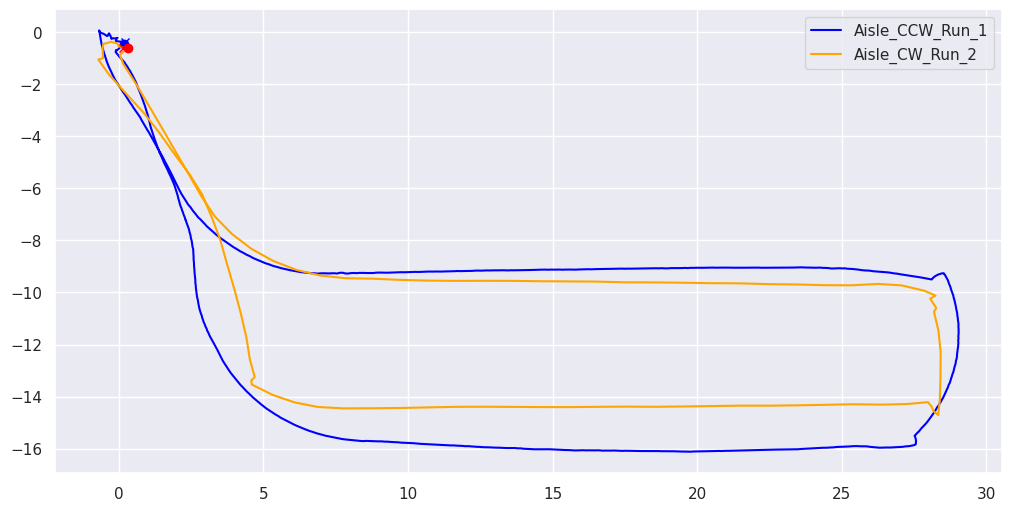

In [2]:
from src.datasets.dataset_utils import read_intrinsics, load_tum_poses, PoseMode

dataset_root = Path("/home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/")
exps_root = Path("results/mast3rvloc-torwic/")

REF_DAY = "Jun15"
REF_RUN = "Aisle_CCW_Run_1"
QUERY_DAY = "Jun23"
QUERY_RUN = "Aisle_CW_Run_2"

# strip _ from Ref RUN and make Ref day and ref run lowercase and build the experiment name
experiment_name = f"{REF_DAY.lower()}-{REF_RUN.replace('_', '').lower()}-query-{QUERY_DAY.lower()}-{QUERY_RUN.replace('_', '').lower()}-asmk-retrieval"

exp_folder = exps_root / experiment_name
exp_folder.mkdir(parents=True, exist_ok=True)

ref_scene_folder = dataset_root / REF_DAY / REF_RUN
query_scene_folder = dataset_root / QUERY_DAY / QUERY_RUN

ref_poses_file = ref_scene_folder / "poses_camera_right_tum.txt"
ref_poses = load_tum_poses(ref_poses_file, PoseMode.TUM)
ref_rgb_folder = ref_scene_folder / "image_right"
ref_rgb_files = natsorted(list(ref_rgb_folder.glob("*.png")))
ref_depth_folder = ref_scene_folder / "depth_right"
ref_depth_files = natsorted(list(ref_depth_folder.glob("*.png")))
assert len(ref_rgb_files) == ref_poses.shape[0]
print(f"ref poses: {ref_poses.shape}")

query_poses_file = query_scene_folder / "poses_camera_right_tum.txt"
query_poses = load_tum_poses(query_poses_file, PoseMode.TUM)
query_rgb_folder = query_scene_folder / "image_right"
query_rgb_files = natsorted(list(query_rgb_folder.glob("*.png")))

RESIZE_COMMON = [512, 288]
intrinsics_dicts = read_intrinsics(ref_scene_folder / "intrinsics_right.txt", resize=RESIZE_COMMON)
K_common, W_orig, H_orig = intrinsics_dicts['K3x3'], intrinsics_dicts['width'], intrinsics_dicts['height']
print(f"K:\n{K_common},\nW: {W_orig}, H: {H_orig}")

# subsample query poses
SUBSAMPLE_FACTOR = 10
query_poses = query_poses[::SUBSAMPLE_FACTOR]
print(f"query poses: {query_poses.shape}")

# plot trajectory
plt.figure(figsize=(10, 5))
plt.plot(ref_poses[:, 1], ref_poses[:, 2], label=f"{ref_scene_folder.name}", color='blue')
plt.plot(ref_poses[0, 1], ref_poses[0, 2], 'bo')
plt.plot(ref_poses[-1, 1], ref_poses[-1, 2], 'bx')

plt.plot(query_poses[:, 1], query_poses[:, 2], label=f"{query_scene_folder.name}", color='orange')
plt.plot(query_poses[0, 1], query_poses[0, 2], 'ro')
plt.plot(query_poses[-1, 1], query_poses[-1, 2], 'rx')
plt.legend()
# plt.show()
# save plot
plt.savefig(exp_folder / "trajectory_original.png")


100%|██████████| 106/106 [00:00<00:00, 102773.05it/s]


Retrieved ref poses: 106


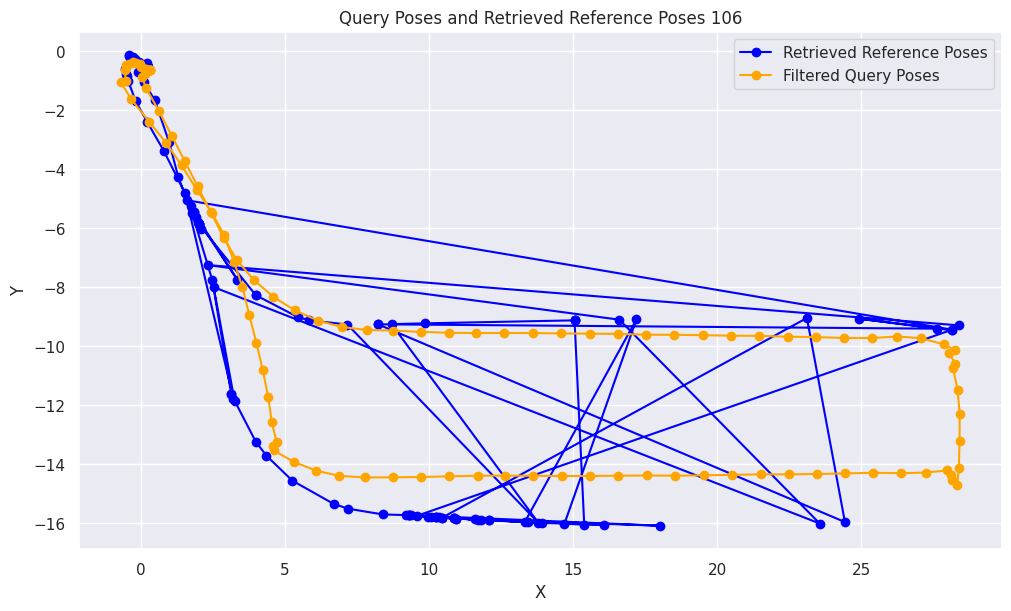

In [3]:
retrieval_file = exps_root / "asmk-retrievals" / f"{REF_DAY.lower()}-{REF_RUN.replace('_', '').lower()}-query-{QUERY_DAY.lower()}-{QUERY_RUN.replace('_', '').lower()}-asmk" / "query_retrieval_asmk.txt"
# read retrieval file as numpy array
retrieval_data = np.loadtxt(retrieval_file, delimiter=' ')    

# Lists to store filtered poses
retrieved_ref_poses = []
filtered_query_poses = []

# read retrieval file as numpy array
retrieval_data = np.loadtxt(retrieval_file, delimiter=' ')    

# Lists to store filtered poses
retrieved_ref_poses = []
filtered_query_poses = []

for query_pose in tqdm(query_poses):
    query_idx = int(query_pose[0])
    
    query_retrieval = retrieval_data[retrieval_data[:, 0] == query_idx][0]
    ref_idx = int(query_retrieval[1])

    retrieved_ref_poses.append(ref_poses[ref_idx])
    filtered_query_poses.append(query_pose)


# Convert lists to numpy arrays for easier plotting
retrieved_ref_positions = np.array(retrieved_ref_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3
filtered_query_positions = np.array(filtered_query_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3

# write poses to file in tum format with timestamps as index
def write_tum_poses(file_path, poses):
    with open(file_path, 'w') as f:
        # simply write the poses as they are
        for pose in poses:
            f.write(" ".join(map(str, pose)) + "\n")

retrieved_ref_poses_file = exp_folder / "retrieved_ref_poses_tum.txt"
filtered_query_poses_file = exp_folder / "filtered_query_poses_tum.txt"

write_tum_poses(retrieved_ref_poses_file, retrieved_ref_poses)
write_tum_poses(filtered_query_poses_file, filtered_query_poses)

print(f"Retrieved ref poses: {len(retrieved_ref_poses)}")

# Plot the query poses and retrieved reference poses
plt.figure(figsize=(10, 6))

plt.plot(retrieved_ref_positions[:, 0], retrieved_ref_positions[:, 1], 'bo-', label='Retrieved Reference Poses')
plt.plot(filtered_query_positions[:, 0], filtered_query_positions[:, 1], 'o-', color='orange', label='Filtered Query Poses')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Query Poses and Retrieved Reference Poses {len(retrieved_ref_poses)}') 
plt.legend()

# plt.show()
plt.savefig(exp_folder / "trajectory_filtered.png")

In [4]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device) # 3.178 GB model

/scratch/public_scratch/toponav/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/scratch/public_scratch/toponav/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda
... loading model from ./checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [5]:
import pickle
from mast3r_src.fast_nn import fast_reciprocal_NNs
from src.utils.tf_utils import compose_qt_tf, decompose_tf_qt
from src.utils.pose_solver import PnPSolver, backproject_3d
device = 'cuda'

# make a folder inside exps that will store the inliers and predicted depths
mast3r_inliers_folder = exp_folder / "mast3r_inliers"
mast3r_inliers_folder.mkdir(parents=True, exist_ok=True)


FILTERED_COUNT = len(filtered_query_poses)
pred_poses_list_kitti = []
pred_poses_list_tum = []

for i in range(FILTERED_COUNT):
    image_q_path = query_rgb_files[int(filtered_query_poses[i][0])]
    image_r_path = ref_rgb_files[int(retrieved_ref_poses[i][0])]
    depth_r_path = ref_depth_files[int(retrieved_ref_poses[i][0])]
    
    # depth_im0_sensor = cv2.imread(str(depth_r_path), cv2.IMREAD_UNCHANGED)


    images = load_images([str(image_r_path), str(image_q_path)], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    # print(f'view1: {view1["true_shape"]}, pred1: {pred1["desc"].shape}, {pred1["pts3d"].shape}')
    view2, pred2 = output['view2'], output['pred2']

    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                    device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

    # 1. read from sensor
    # depth_im0 = depth_im0_sensor.astype(np.float32) / 1000.0
    # 2. use from mast3r
    depth_im0 = pred1['pts3d'][..., 2].squeeze(0).cpu().numpy()

    # run PnP solver
    solver = PnPSolver()
    R, t, inliers, reproj_errs = solver.estimate_pose(matches_im0, matches_im1, depth_im0, K_common)
    
    # reference tranform
    retrieved_ref_pose = retrieved_ref_poses[i]
    qvec_w2ref = retrieved_ref_pose[4:]
    tvec_w2ref = retrieved_ref_pose[1:4]
    timestamp = retrieved_ref_pose[0]
    tf_w2ref= compose_qt_tf(qvec_w2ref, tvec_w2ref, in_xyzw=True)
    
    if np.isnan(R).any():
        T_w2query =  np.eye(4)
        inliers = np.array([])
        reproj_errs = np.array([])
    else:
        tf_query2ref = np.eye(4)
        tf_query2ref[:3, :3] = R
        tf_query2ref[:3, 3] = t.squeeze()

        # save inlier matches and corresponding pts3d
        sorted_indices = np.argsort(reproj_errs[inliers].flatten())
        inliers = inliers[sorted_indices]
        reproj_errs = reproj_errs[inliers]
        matches_im0_inliers, matches_im1_inliers = matches_im0[inliers], matches_im1[inliers]
        depth_inliers = depth_im0[matches_im0_inliers[:, 1].astype(int), matches_im0_inliers[:, 0].astype(int)]
        xyz_0_inliers = backproject_3d(matches_im0_inliers, depth_inliers, K_common)

        inliers_file = mast3r_inliers_folder / f"query_{int(filtered_query_poses[i][0])}_inliers.pkl"
        H0W0, H1W1 = tuple(map(int, (H_orig, W_orig))), tuple(map(int, (H_orig, W_orig)))
        H0W0_RESIZE, H1W1_RESIZE = RESIZE_COMMON[::-1], RESIZE_COMMON[::-1]
        
        with open(inliers_file, 'wb') as f:
            pickle.dump({'matches_im0': matches_im0_inliers, 'matches_im1': matches_im1_inliers, 'xyz_0': xyz_0_inliers,
                            'H0W0': H0W0, 'H1W1': H1W1, 'H0W0_RESIZE': H0W0_RESIZE, 'H1W1_RESIZE': H1W1_RESIZE}, f)
        print(f"> Saved inliers to {inliers_file}")

        # transform from current reference (relative) to global by multiplying with reference pose
        T_w2query =  tf_w2ref @ np.linalg.inv(tf_query2ref)
    
    quat_w2query, tvec_w2query = decompose_tf_qt(T_w2query, in_xyzw=True)
    
    pred_poses_list_tum.append([timestamp, *tvec_w2query, *quat_w2query])

pred_poses_tum = np.array(pred_poses_list_tum)
pred_poses_file_tum = exp_folder / 'pred_poses_tum_query_down.txt'
write_tum_poses(pred_poses_file_tum, pred_poses_tum)
print(f'> Saved GT camera poses to {pred_poses_file_tum}')

>> Loading a list of 2 images
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000043.png with resolution 1280x720 --> 512x288
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun23/Aisle_CW_Run_2/image_right/000000.png with resolution 1280x720 --> 512x288
 (Found 2 images)


/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/inference.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


> Saved inliers to results/mast3rvloc-torwic/jun15-aisleccwrun1-query-jun23-aislecwrun2-asmk-retrieval/mast3r_inliers/query_0_inliers.pkl
>> Loading a list of 2 images
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000043.png with resolution 1280x720 --> 512x288
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun23/Aisle_CW_Run_2/image_right/000010.png with resolution 1280x720 --> 512x288
 (Found 2 images)
> Saved inliers to results/mast3rvloc-torwic/jun15-aisleccwrun1-query-jun23-aislecwrun2-asmk-retrieval/mast3r_inliers/query_10_inliers.pkl
>> Loading a list of 2 images
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000043.png with resolution 1280x720 --> 512x288
 - adding /home/onyx/work_dirs/rjayanti/mast3r-vloc/data/TorWIC-SLAM/Jun23/Aisle_CW_Run_2/image_right/000020.png with resolution 1280x720 --> 512x288
 (Found 2 images)
> Saved inliers to result

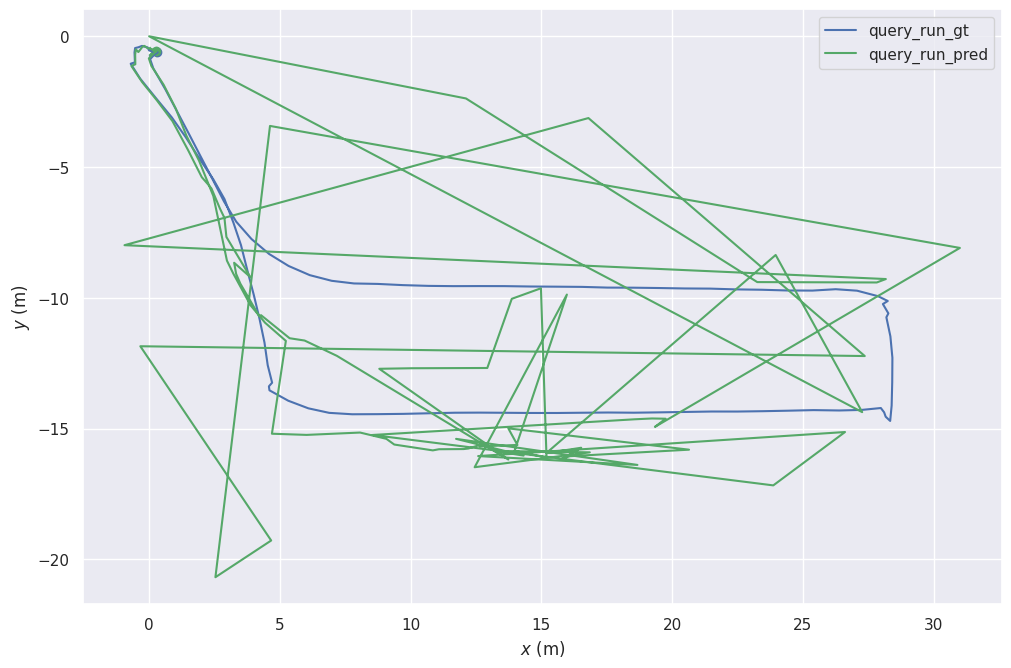

In [6]:
tum_mapping = file_interface.read_tum_trajectory_file(retrieved_ref_poses_file)
tum_query_gt = file_interface.read_tum_trajectory_file(filtered_query_poses_file)
tum_query_pred = file_interface.read_tum_trajectory_file(pred_poses_file_tum)

fig = plt.figure(figsize=(10, 20))
traj_by_label = {
    # "mapping_run": tum_mapping, 
    "query_run_gt": tum_query_gt,
    "query_run_pred": tum_query_pred,
}

plot.trajectories(fig, traj_by_label, plot.PlotMode.xy, plot_start_end_markers=True)
# plt.show()
plt.savefig(exp_folder / "trajectory_comparison.png")

{'max': 29.327515540851813,
 'mean': 5.102635860009499,
 'median': 2.7688708718377852,
 'min': 0.03827861102209922,
 'rmse': 8.551166547302687,
 'sse': 7750.979627889108,
 'std': 6.861891619652243}


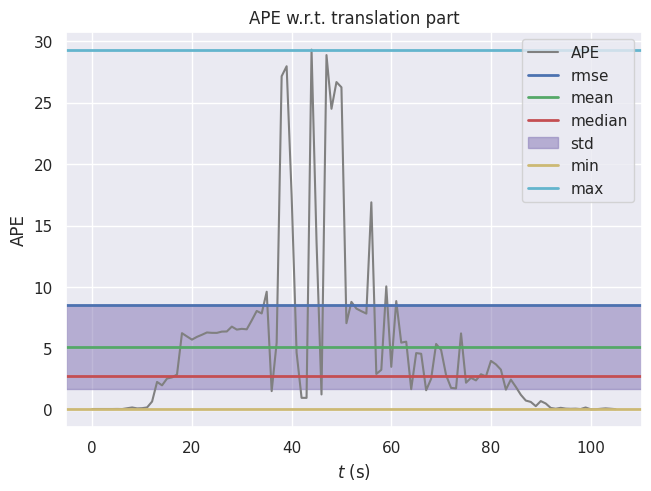

In [7]:
import json
pose_relation = metrics.PoseRelation.translation_part
data = (tum_query_gt, tum_query_pred)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)
# save ape stats as json
ape_stats_file = exp_folder / "ape_stats.json"
with open(ape_stats_file, 'w') as f:
    json.dump(ape_stats, f, indent=4)

fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error,
                statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
# plt.show()
plt.savefig(exp_folder / "trajectory_ape.png")

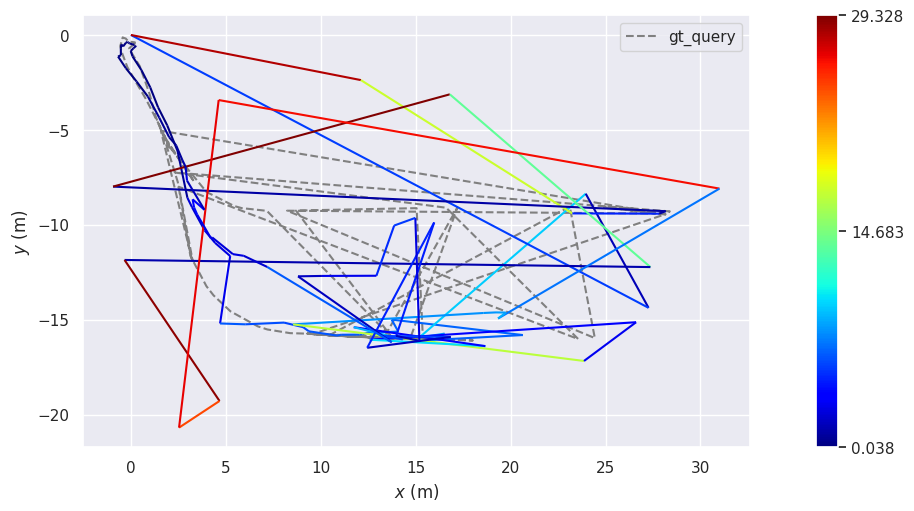

In [8]:
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15, 5))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, tum_mapping, '--', "gray", "gt_query")
plot.traj_colormap(ax, tum_query_pred, ape_metric.error, plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
# plt.show()
plt.savefig(exp_folder / "trajectory_ape_colormap.png")